# Programming Demo: Opinion Models 

In this notebook, we'll code up some variations on the consensus dynamics model that we discussed in lecture. We'll again be using the Mesa framework. From a programming perspective, we're going to be demonstrating a few different things: 

- Models with multiple agents. 
- Models with multiple **types** of agents. 
- Synchronous schedulers, which cause all agents to interact simultaneously. 

Let's get started! 

In [1]:
from mesa import Model, Agent                 # core mesa classes
from mesa.space import NetworkGrid             
from mesa.time import SimultaneousActivation           
from mesa.datacollection import DataCollector

import networkx as nx                         # for the grid
import numpy as np                            # computations
import seaborn as sns                         # install the seaborn package in your Python environment if this line doesn't run. 
from matplotlib import pyplot as plt

Like last time, the first thing we are going to do is define a *model* class. The model describes the overall system, and primarily handles setup: putting agents in the right place, initializing their parameters, adding them to the schedule, etc. 

A nice thing about using a framework like Mesa: this model is pretty similar to the random walk and PageRank models we discussed previously! The main difference is in the addition of multiple agents to the grid, and with the use of the `SimultaneousActivation` scheduler that allows all agents to act simultaneously. 

I encourage you to study this implementation and compare it to the one we did previously. 

In [3]:
class OpinionModel(Model):

    # model setup
    def __init__(self, G, agent_class, x0 = None, beta = None, **kwargs):

        self.schedule = SimultaneousActivation(self) 
        self.grid = NetworkGrid(G)            
        
        assert len(x0) == len(G.nodes)

        node_list = list(G.nodes)

        # place multiple agents, each with an initial opinion
        for i in range(len(x0)):
            node = node_list[i]
            agent = agent_class(node, self, x = x0[i], beta = beta[i], **kwargs)
            self.grid.place_agent(agent, node)
            self.schedule.add(agent)

        self.collector = DataCollector(
            agent_reporters = {
                "Opinion" : lambda a: a.x
            }
        )

    def step(self):
        self.schedule.step()
        self.collector.collect(self)

Now let's implement the agent class we'll use for the demonstration. Our agent class is intentionally designed to be pretty flexible. Every agent has an opinion $x$, an update function $F$, and some additional parameters that can be passed to the update function. 

In [4]:
class OpinionAgent(Agent):

    def __init__(self, agent_id, model, x, F, **kwargs):
        super().__init__(agent_id, model)
        self.x = x
        self.kwargs = kwargs
        self.F = F

    def step(self):

        # TO FILL IN

    # this method is required by the synchronous scheduler
    # this is where each node actually changes its opinion. 
    def advance(self):
        self.x = self.x_next

We're *almost* done with our model implementation! In order to implement a given model, we need to specify the function $F$. Let's code up the update for consensus dynamics: 

In [18]:
def F_consensus(center, neighbors, beta = 1):
    # TO FILL IN

The next function performs a simulation for 1,000 timesteps and plots the evolution of each node's opinion. 

In [19]:
def opinion_dynamics_experiment(G, F, x0, beta, **kwargs):
    
    model = OpinionModel(G, OpinionAgent, x0 = x0, beta = beta, F = F, **kwargs)

    for i in range(1000):
        model.step()

    report = model.collector.get_agent_vars_dataframe().reset_index()

    fig = sns.lineplot(data = report, 
                       x = "Step", 
                       y = "Opinion", 
                       hue = "AgentID", 
                       legend = False)

    plt.gca().set_xscale("log")

Ok, experiment time! 

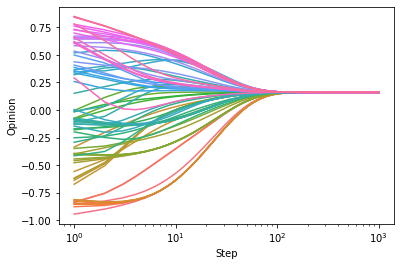

In [26]:
G = nx.les_miserables_graph()
n = len(G.nodes())
x0 = np.sort(2*np.random.rand(n) - 1)
beta = 0.5*np.ones(n)
    
opinion_dynamics_experiment(G, F_consensus, x0, beta)

As predicted by theory, all the nodes eventually converge to consensus --- they all have the same opinion. 

One way to disrupt this behavior is by making some of the nodes *stubborn*, so that they never change their opinions. Let's try this: 

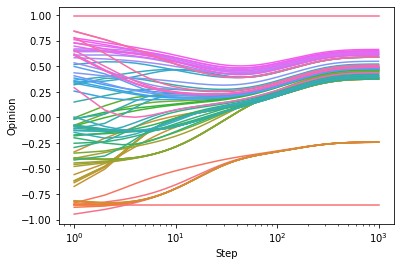

In [27]:
beta[2]  = 0
beta[-1] = 0

opinion_dynamics_experiment(G, F_consensus, x0, beta)

This time, no consensus is reached, although the nodes do still tend to group together.  

In the *bounded confidence* model, nodes only interact with other nodes that are close to them in opinion space. To implement this, we just need to choose a different update function $F$. 

Because in BC models it is possible that eventually a node has no neighbors with whom it can interact, we explicit state that, in this case, no update occurs. 

In [33]:
def F_bounded_confidence(center, neighbors, beta = 1, c = np.Inf):
    neighbor_opinions = [a.x for a in neighbors if np.abs(a.x - center.x) < c]
    if len(neighbor_opinions) > 0:
        neighbor_avg = np.mean(neighbor_opinions)
        return (1-beta)*center.x + beta*neighbor_avg
    else:
        return center.x

Ok, experiment time: 

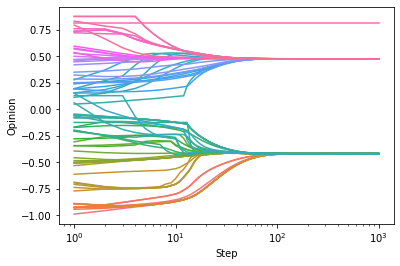

In [35]:
x0 = np.sort(2*np.random.rand(n) - 1)
beta = 0.5*np.ones(n)
opinion_dynamics_experiment(G, F_bounded_confidence, x0, beta, c = 0.4)